In [1]:
import importlib
import data_preprocessing
import data_set_and_loader
import models.multihead_pitch_prediction
import pandas as pd
from layers.lstm import LSTM
importlib.reload(data_preprocessing)
importlib.reload(data_set_and_loader)
importlib.reload(models.multihead_pitch_prediction)

<module 'models.multihead_pitch_prediction' from 'c:\\Users\\Richard\\Documents\\SEG4300\\Project\\SEG4300-Project\\Code\\models\\multihead_pitch_prediction.py'>

In [2]:
import torch
from torch import nn
import torch.optim as optim
import os
import time
from models.multihead_pitch_prediction import MultiHeadLSTM
from data_preprocessing import load_data, sort_n_group, build_seqs, encode_and_scale, compute_feature_medians, split_data
from data_set_and_loader import create_dataloaders, AtBatDataset
from config import DATA_PATH

In [3]:
df = load_data(DATA_PATH)

In [4]:
df = sort_n_group(df)

In [5]:
median_values = compute_feature_medians(df)

In [6]:
print(median_values)

{'release_speed': np.float64(90.3), 'release_spin_rate': np.float64(2274.0), 'release_extension': np.float64(6.3), 'plate_x': np.float64(0.04), 'plate_z': np.float64(2.28)}


In [7]:
X_sequences , Y_sequences = build_seqs(df, median_values)

Finished sequence building. Dropped 52454 at-bats with NaN values.
Dropped 145305 at-bats due to outliers.
Dropped 8496 at-bats due to invalid results: {'strikeout_double_play', 'truncated_pa', 'strikeout', 'walk'}


In [8]:
num_indices = [8, 9, 16, 17, 18, 19, 20]
cat_indices = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 21, 22]

processed_X, processed_Y, label_encoders_X, y_type_encoder, y_desc_encoder, y_event_encoder = encode_and_scale(X_sequences, Y_sequences)

In [9]:
X_train, X_test, Y_train, Y_test = split_data(processed_X, processed_Y, test_size=0.2, random_state=42)

In [10]:
train_loader, test_loader = create_dataloaders(X_train, Y_train, X_test, Y_test, 128) #remember to adjust batch-size here too

In [11]:
x_num_indices = [8, 9, 16, 17, 18, 19, 20]
x_low_card_cats_indices = [0, 1, 2, 3, 4, 5, 7, 10, 11, 14]
x_inning_index = 6
x_pitcher_index = 12
x_batter_index = 13
x_prev_pitch_index = 15
x_prev_desc_index = 22
x_prev_event_index = 21

In [12]:
EPOCHS = 50
BATCH_SIZE = 128
LEARNING_RATE = 0.002
MODEL_SAVE_PATH = r"C:\Users\Richard\Documents\SEG4300\Project\SEG4300-Project\Code\saved_models\best_model.pth"
history = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model (update parameters based on your dataset)
model = MultiHeadLSTM(
    #INCREASE DIMS??
    num_numeric_features=7,
    num_pitchers=879, num_batters=3096,
    num_prev_descriptions=12, num_prev_events=3, num_prev_pitch_types=16,
    num_low_card_cats=10, 
    num_innings=20, inning_emb_dim=4,
    pitcher_emb_dim=30, batter_emb_dim=50,
    prev_description_emb_dim=4, prev_event_emb_dim=2, prev_pitch_emb_dim=4,
    hidden_dim=128,
    num_pitch_type_classes=16, num_description_classes=14, num_event_classes=24,
    cont_dim=5, lstm_layers=2, dropout=0.2
).to(device)

# Loss functions
criterion_classification = nn.CrossEntropyLoss(ignore_index=0)
criterion_continuous = nn.MSELoss(reduction="none")

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Learning rate scheduler: Reduce LR by 50% every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# Track best validation loss
best_val_loss = float("inf")


### 🚀 Training Function
def train_one_epoch(epoch):
    model.train()
    total_loss, total_pitch_type_loss, total_desc_loss, total_event_loss, total_cont_loss = 0, 0, 0, 0, 0
    correct_pitch_types, correct_desc, correct_event = 0, 0, 0
    total_pitch_types, total_desc, total_event = 0, 0, 0

    start_time = time.time()

    for batch in train_loader:
        (
            padded_X, padded_Y_type, padded_Y_cont, padded_Y_desc, padded_Y_event, lengths
        ) = [tensor.to(device) for tensor in batch]

        # Extract features based on new indices
        x_num = padded_X[:, :, x_num_indices]  # Numeric features
        x_low_card_cats = padded_X[:, :, x_low_card_cats_indices]  # Low-cardinality categorical
        x_inning = padded_X[:, :, x_inning_index].long()  # Inning (integer categories)
        x_pitcher = padded_X[:, :, x_pitcher_index].long()
        x_batter = padded_X[:, :, x_batter_index].long()
        x_prev_pitch = padded_X[:, :, x_prev_pitch_index].long()
        x_prev_desc = padded_X[:, :, x_prev_desc_index].long()
        x_prev_event = padded_X[:, :, x_prev_event_index].long()

        optimizer.zero_grad()

        # Forward pass
        pitch_type_logits, pitch_cont_values, pitch_result_desc, pitch_result_event = model(
            x_num, x_low_card_cats, x_inning, x_pitcher, x_batter, x_prev_desc, x_prev_event, x_prev_pitch, lengths
        )

        # Compute losses
        loss_pitch_type = criterion_classification(
            pitch_type_logits.view(-1, pitch_type_logits.size(-1)), padded_Y_type.view(-1)
        )
        loss_desc = criterion_classification(
            pitch_result_desc.view(-1, pitch_result_desc.size(-1)), padded_Y_desc.view(-1)
        )
        loss_event = criterion_classification(
            pitch_result_event.view(-1, pitch_result_event.size(-1)), padded_Y_event.view(-1)
        )
        #Handle padded numerical values (-999) in MSE loss
        mask = (padded_Y_cont != -999).float()  # Create a mask (1 for real values, 0 for padded)
        loss_cont = (mask * (pitch_cont_values - padded_Y_cont) ** 2).sum() / mask.sum()

        # Total loss
        loss = loss_pitch_type + loss_desc + loss_event + loss_cont
        loss.backward()
        optimizer.step()

        # Track losses
        total_loss += loss.item()
        total_pitch_type_loss += loss_pitch_type.item()
        total_desc_loss += loss_desc.item()
        total_event_loss += loss_event.item()
        total_cont_loss += loss_cont.item()

        # Compute accuracy for all categorical outputs (ignore padding)
        mask_type = (padded_Y_type != 0)  
        mask_desc = (padded_Y_desc != 0)
        mask_event = (padded_Y_event != 0)

        _, predicted_pitch_type = torch.max(pitch_type_logits, dim=-1)
        _, predicted_desc = torch.max(pitch_result_desc, dim=-1)
        _, predicted_event = torch.max(pitch_result_event, dim=-1)

        correct_pitch_types += (predicted_pitch_type[mask_type] == padded_Y_type[mask_type]).sum().item()
        correct_desc += (predicted_desc[mask_desc] == padded_Y_desc[mask_desc]).sum().item()
        correct_event += (predicted_event[mask_event] == padded_Y_event[mask_event]).sum().item()

        total_pitch_types += mask_type.sum().item()
        total_desc += mask_desc.sum().item()
        total_event += mask_event.sum().item()

    avg_loss = total_loss / len(train_loader)
    pitch_type_acc = 100 * correct_pitch_types / total_pitch_types
    desc_acc = 100 * correct_desc / total_desc
    event_acc = 100 * correct_event / total_event

    end_time = time.time()
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.4f} - Pitch Type Acc: {pitch_type_acc:.2f}% - Desc Acc: {desc_acc:.2f}% - Event Acc: {event_acc:.2f}% - Time: {end_time - start_time:.2f}s")

    history.append({
        "train_pitch_type_acc": pitch_type_acc,
        "train_desc_acc": desc_acc,
        "train_event_acc": event_acc
    })

    return avg_loss


### 🚀 Validation Function
def validate():
    model.eval()
    val_loss, val_pitch_type_loss, val_desc_loss, val_event_loss, val_cont_loss = 0, 0, 0, 0, 0
    correct_pitch_types, correct_desc, correct_event = 0, 0, 0
    total_pitch_types, total_desc, total_event = 0, 0, 0

    with torch.no_grad():
        for batch in test_loader:
            (
                padded_X, padded_Y_type, padded_Y_cont, padded_Y_desc, padded_Y_event, lengths
            ) = [tensor.to(device) for tensor in batch]

            # Extract features based on new indices
            x_num = padded_X[:, :, x_num_indices]  # Numeric features
            x_low_card_cats = padded_X[:, :, x_low_card_cats_indices]  # Low-cardinality categorical
            x_inning = padded_X[:, :, x_inning_index].long()  # Inning (integer categories)
            x_pitcher = padded_X[:, :, x_pitcher_index].long()
            x_batter = padded_X[:, :, x_batter_index].long()
            x_prev_pitch = padded_X[:, :, x_prev_pitch_index].long()
            x_prev_desc = padded_X[:, :, x_prev_desc_index].long()
            x_prev_event = padded_X[:, :, x_prev_event_index].long()

            pitch_type_logits, pitch_cont_values, pitch_result_desc, pitch_result_event = model(
                x_num, x_low_card_cats, x_inning, x_pitcher, x_batter, x_prev_desc, x_prev_event, x_prev_pitch, lengths
            )

            # Compute validation losses
            loss_pitch_type = criterion_classification(
                pitch_type_logits.view(-1, pitch_type_logits.size(-1)), padded_Y_type.view(-1)
            )
            loss_desc = criterion_classification(
                pitch_result_desc.view(-1, pitch_result_desc.size(-1)), padded_Y_desc.view(-1)
            )
            loss_event = criterion_classification(
                pitch_result_event.view(-1, pitch_result_event.size(-1)), padded_Y_event.view(-1)
            )
            mask = (padded_Y_cont != -999).float()
            loss_cont = (mask * (pitch_cont_values - padded_Y_cont) ** 2).sum() / mask.sum()

            loss = loss_pitch_type + loss_desc + loss_event + loss_cont
            val_loss += loss.item()

            # Compute accuracy for all categorical outputs (ignore padding)
            mask_type = (padded_Y_type != 0)  
            mask_desc = (padded_Y_desc != 0)
            mask_event = (padded_Y_event != 0)

            _, predicted_pitch_type = torch.max(pitch_type_logits, dim=-1)
            _, predicted_desc = torch.max(pitch_result_desc, dim=-1)
            _, predicted_event = torch.max(pitch_result_event, dim=-1)

            correct_pitch_types += (predicted_pitch_type[mask_type] == padded_Y_type[mask_type]).sum().item()
            correct_desc += (predicted_desc[mask_desc] == padded_Y_desc[mask_desc]).sum().item()
            correct_event += (predicted_event[mask_event] == padded_Y_event[mask_event]).sum().item()

            total_pitch_types += mask_type.sum().item()
            total_desc += mask_desc.sum().item()
            total_event += mask_event.sum().item()

    avg_val_loss = val_loss / len(test_loader)
    pitch_type_acc = 100 * correct_pitch_types / total_pitch_types
    desc_acc = 100 * correct_desc / total_desc
    event_acc = 100 * correct_event / total_event

    print(f"Validation Loss: {avg_val_loss:.4f} - Pitch Type Acc: {pitch_type_acc:.2f}% - Desc Acc: {desc_acc:.2f}% - Event Acc: {event_acc:.2f}%")

    history.append({
        "val_pitch_type_acc": pitch_type_acc,
        "val_desc_acc": desc_acc,
        "val_event_acc": event_acc
    })

    return avg_val_loss


early_stopping_patience = 5
no_improvement_epochs = 0

### 🚀 Training Loop
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(epoch)
    val_loss = validate()

    history.append({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "val_loss": val_loss
    })

    if val_loss < best_val_loss:
        print("🔥 New best model found! Saving...")
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        model.save_model_config()
        best_val_loss = val_loss
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1

    scheduler.step()

    if no_improvement_epochs >= early_stopping_patience:
        print("Early stopping triggered")
        break

df_history = pd.DataFrame(history)
df_history.to_csv(r"C:\Users\Richard\Documents\SEG4300\Project\SEG4300-Project\Code\saved_models\training_metrics.csv", index=False)
print("Training complete! Best model saved as", MODEL_SAVE_PATH)

Using device: cpu
Epoch [1/50] - Loss: 5.0442 - Pitch Type Acc: 44.39% - Desc Acc: 37.17% - Event Acc: 50.12% - Time: 404.48s
Validation Loss: 4.7805 - Pitch Type Acc: 47.22% - Desc Acc: 37.75% - Event Acc: 51.03%
🔥 New best model found! Saving...
Model config saved to C:\Users\Richard\Documents\SEG4300\Project\SEG4300-Project\Code\saved_models\model_config.txt
Epoch [2/50] - Loss: 4.7658 - Pitch Type Acc: 47.31% - Desc Acc: 37.79% - Event Acc: 51.19% - Time: 404.00s
Validation Loss: 4.7285 - Pitch Type Acc: 47.84% - Desc Acc: 37.90% - Event Acc: 51.37%
🔥 New best model found! Saving...
Model config saved to C:\Users\Richard\Documents\SEG4300\Project\SEG4300-Project\Code\saved_models\model_config.txt
Epoch [3/50] - Loss: 4.7401 - Pitch Type Acc: 47.73% - Desc Acc: 37.94% - Event Acc: 51.36% - Time: 399.01s
Validation Loss: 4.7144 - Pitch Type Acc: 48.15% - Desc Acc: 37.99% - Event Acc: 51.44%
🔥 New best model found! Saving...
Model config saved to C:\Users\Richard\Documents\SEG4300\Pro

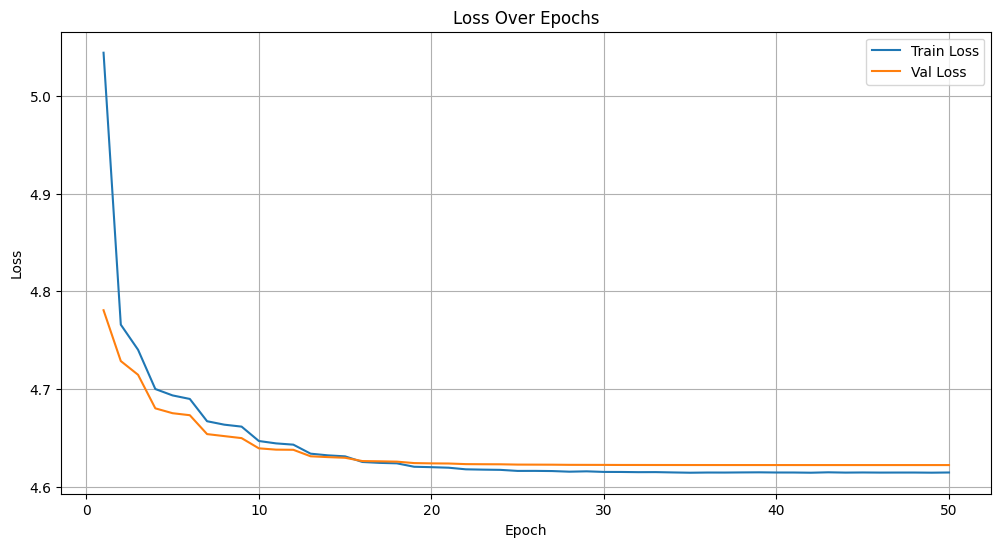

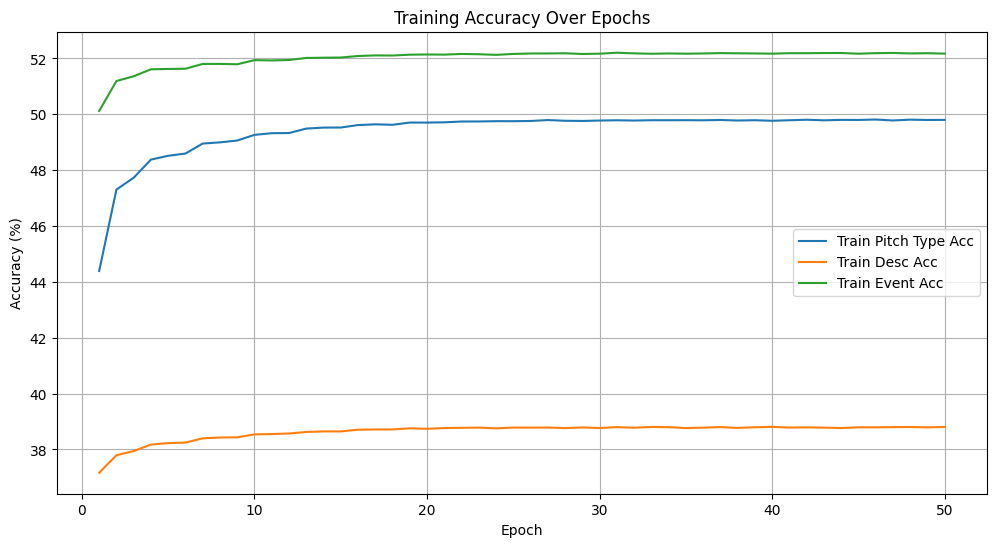

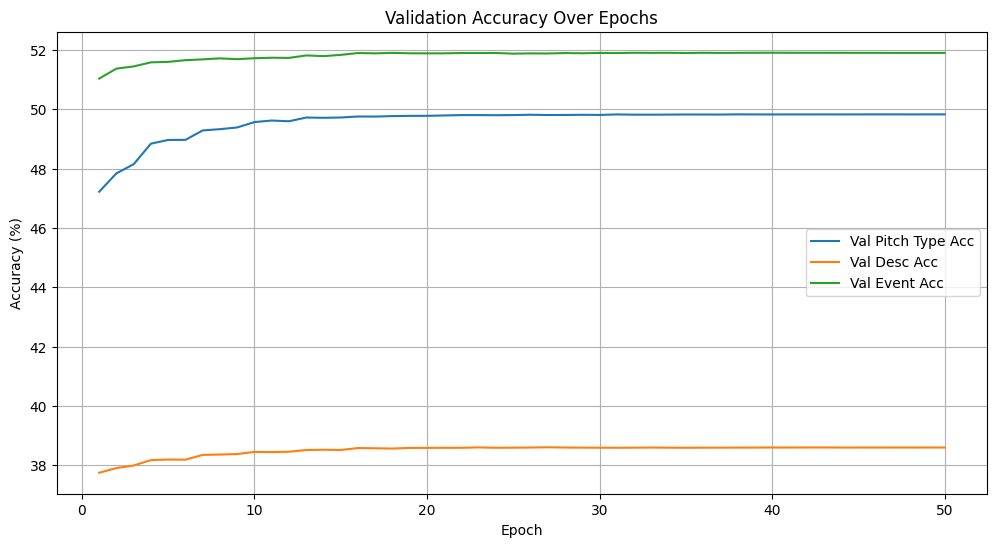

In [26]:
import matplotlib.pyplot as plt

df_history = pd.read_csv(r"C:\Users\Richard\Documents\SEG4300\Project\SEG4300-Project\Code\saved_models\training_metrics.csv")

rows_per_epoch = 3
num_epochs = len(df_history) // rows_per_epoch

cleaned_rows = []

for i in range(num_epochs):
    base_idx = i * rows_per_epoch

    row_train_acc = df_history.iloc[base_idx]
    row_val_acc = df_history.iloc[base_idx + 1]
    row_loss = df_history.iloc[base_idx + 2]

    combined_row = {
        "epoch": row_loss["epoch"],
        "train_loss": row_loss["train_loss"],
        "val_loss": row_loss["val_loss"],
        "train_pitch_type_acc": row_train_acc["train_pitch_type_acc"],
        "train_desc_acc": row_train_acc["train_desc_acc"],
        "train_event_acc": row_train_acc["train_event_acc"],
        "val_pitch_type_acc": row_val_acc["val_pitch_type_acc"],
        "val_desc_acc": row_val_acc["val_desc_acc"],
        "val_event_acc": row_val_acc["val_event_acc"],
    }

    cleaned_rows.append(combined_row)

df_history = pd.DataFrame(cleaned_rows)

plt.figure(figsize=(12, 6))
plt.plot(df_history["epoch"], df_history["train_loss"], label="Train Loss")
plt.plot(df_history["epoch"], df_history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Epochs")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df_history["epoch"], df_history["train_pitch_type_acc"], label="Train Pitch Type Acc")
plt.plot(df_history["epoch"], df_history["train_desc_acc"], label="Train Desc Acc")
plt.plot(df_history["epoch"], df_history["train_event_acc"], label="Train Event Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Training Accuracy Over Epochs")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df_history["epoch"], df_history["val_pitch_type_acc"], label="Val Pitch Type Acc")
plt.plot(df_history["epoch"], df_history["val_desc_acc"], label="Val Desc Acc")
plt.plot(df_history["epoch"], df_history["val_event_acc"], label="Val Event Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Validation Accuracy Over Epochs")
plt.grid(True)
plt.show()

In [27]:
from sklearn.manifold import TSNE

def plot_embeddings(embedding_matrix, labels, title):
    """
    Visualizes high-dimensional learned embeddings using t-SNE.
    """
    num_samples = embedding_matrix.shape[0]  # Number of embeddings
    perplexity = min(5, num_samples - 1)  # Ensure perplexity < num_samples
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    embedded_2d = tsne.fit_transform(embedding_matrix.cpu().detach().numpy())

    plt.figure(figsize=(10, 7))
    plt.scatter(embedded_2d[:, 0], embedded_2d[:, 1], alpha=0.7, cmap="viridis")
    
    for i, label in enumerate(labels):
        plt.text(embedded_2d[i, 0], embedded_2d[i, 1], str(label), fontsize=9, alpha=0.8)
    
    plt.title(title)
    plt.show()

# Extract learned embeddings
def inspect_learned_embeddings():
    """
    Extracts and visualizes learned embeddings for pitchers, batters, and innings.
    """
    model.eval()
    pitcher_embeddings = model.pitcher_emb.weight
    batter_embeddings = model.batter_emb.weight
    inning_embeddings = model.inning_emb.weight
    prev_desc_embs = model.prev_description_emb.weight
    prev_event_embs = model.prev_event_emb.weight
    prev_pitch_embs = model.prev_pitch_emb.weight

    plot_embeddings(pitcher_embeddings, range(len(pitcher_embeddings)), "Pitcher Embeddings")
    plot_embeddings(batter_embeddings, range(len(batter_embeddings)), "Batter Embeddings")
    plot_embeddings(inning_embeddings, range(len(inning_embeddings)), "Inning Embeddings")
    plot_embeddings(prev_desc_embs, range(len(prev_desc_embs)), "Prev Desc Embeddings")
    plot_embeddings(prev_event_embs, range(len(prev_event_embs)), "Prev Event Embeddings")
    plot_embeddings(prev_pitch_embs, range(len(prev_pitch_embs)), "Prev Pitch Embeddings")



c:\Users\Richard\Documents\SEG4300\Project\SEG4300-Project\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Richard\Documents\SEG4300\Project\SEG4300-Project\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python313\Lib\subprocess.py", line 1036, in __init__
    self._execute_child(args, executable, preexec_

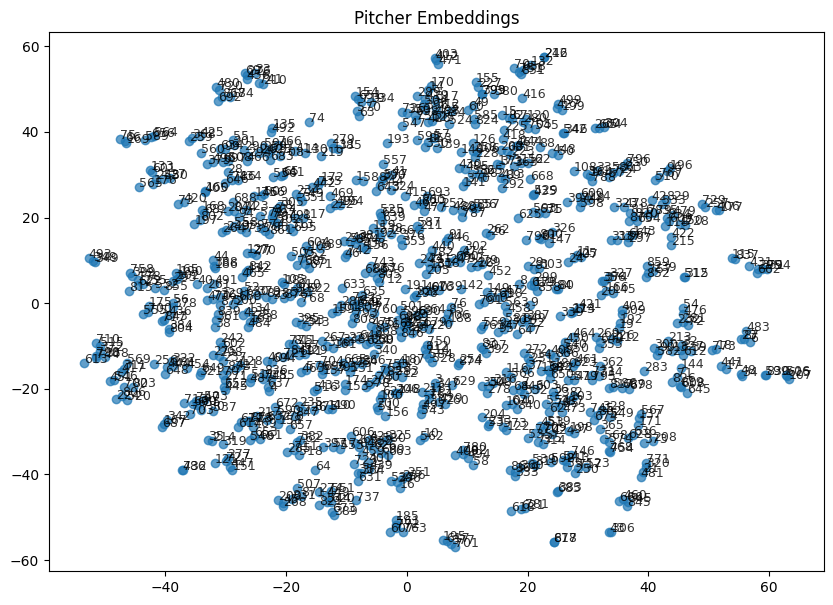

C:\Users\Richard\AppData\Local\Temp\ipykernel_24404\4011387956.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedded_2d[:, 0], embedded_2d[:, 1], alpha=0.7, cmap="viridis")


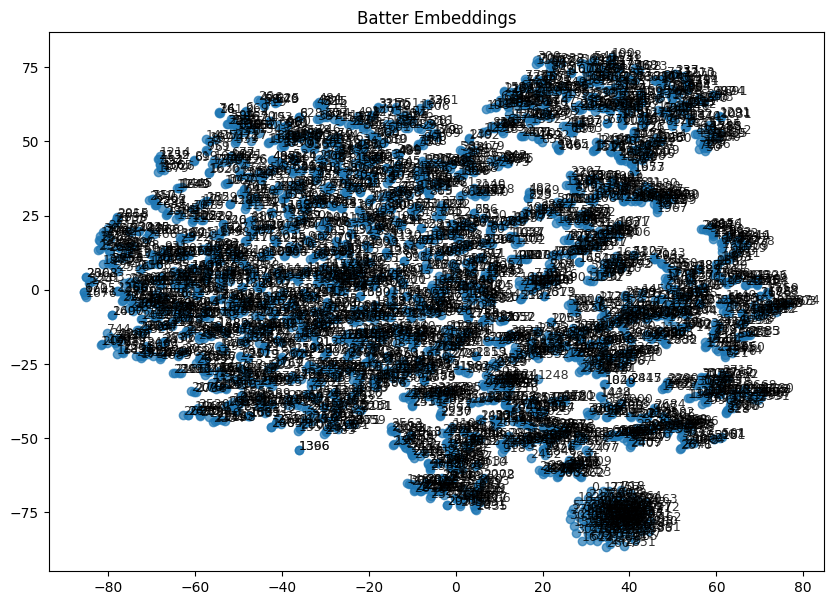

C:\Users\Richard\AppData\Local\Temp\ipykernel_24404\4011387956.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedded_2d[:, 0], embedded_2d[:, 1], alpha=0.7, cmap="viridis")


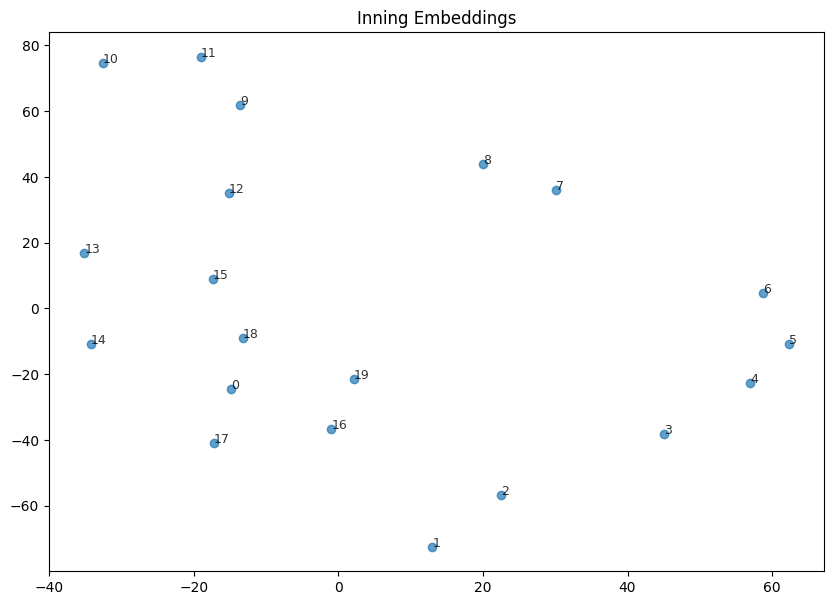

C:\Users\Richard\AppData\Local\Temp\ipykernel_24404\4011387956.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedded_2d[:, 0], embedded_2d[:, 1], alpha=0.7, cmap="viridis")


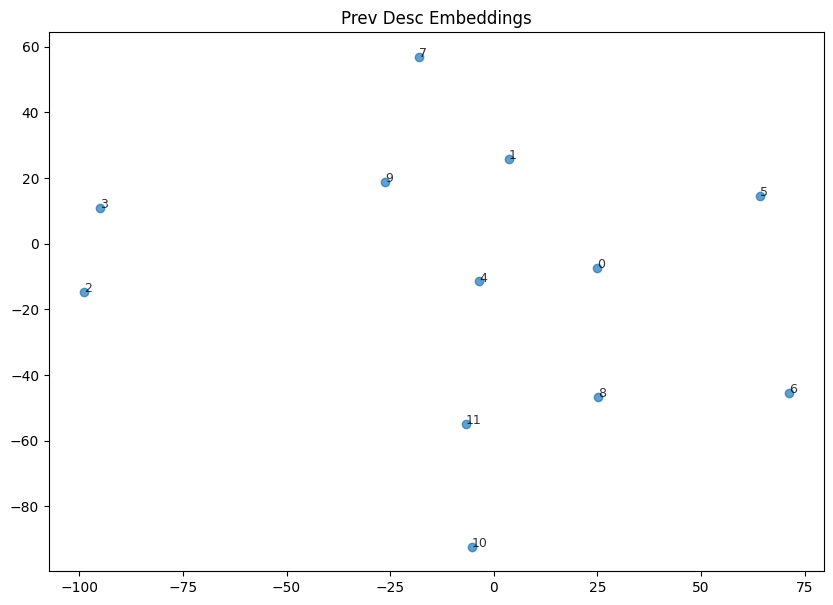

C:\Users\Richard\AppData\Local\Temp\ipykernel_24404\4011387956.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedded_2d[:, 0], embedded_2d[:, 1], alpha=0.7, cmap="viridis")


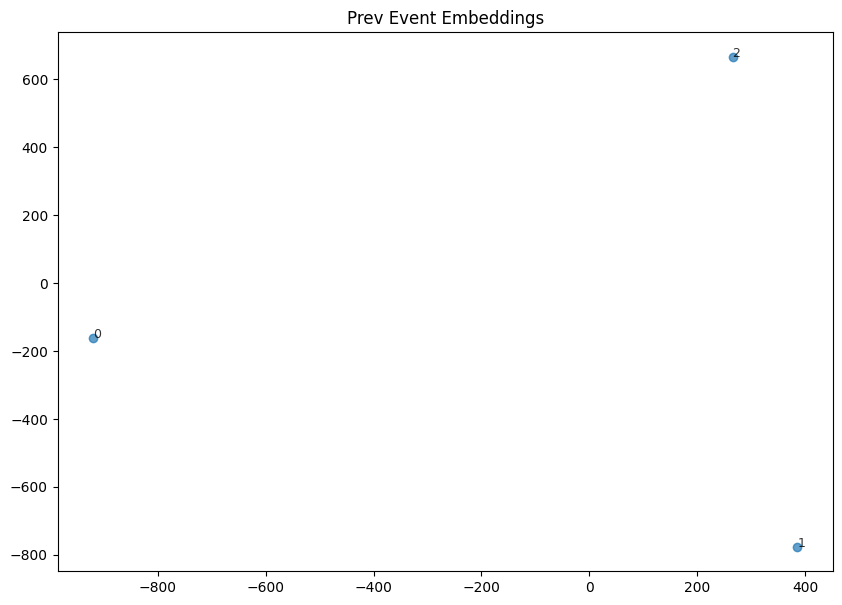

C:\Users\Richard\AppData\Local\Temp\ipykernel_24404\4011387956.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedded_2d[:, 0], embedded_2d[:, 1], alpha=0.7, cmap="viridis")


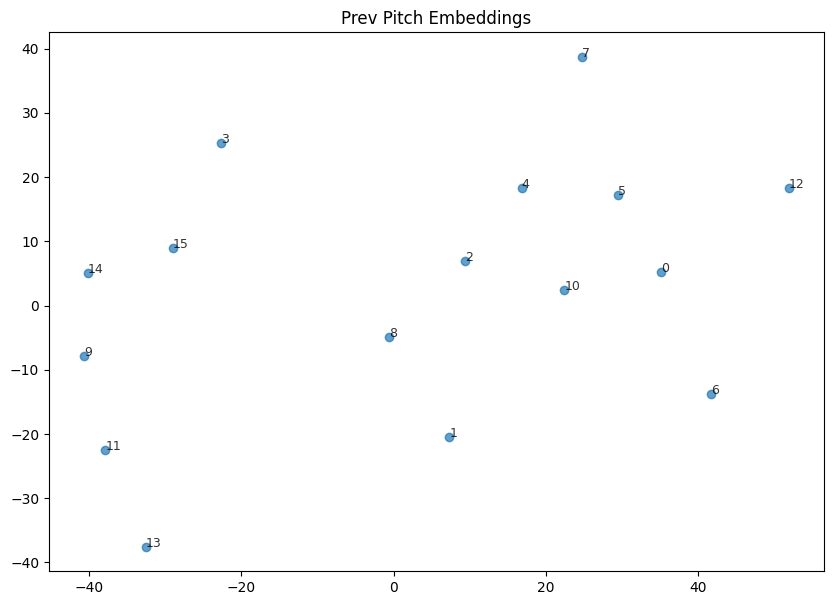

In [28]:
# Visualize LSTM attention for a random batch
#sample_batch = next(iter(test_loader))
#visualize_attention(model, sample_batch, lengths)

# Inspect learned pitcher/batter/inning embeddings
inspect_learned_embeddings()

C:\Users\Richard\AppData\Local\Temp\ipykernel_24404\3133360027.py:20: RuntimeWarning: divide by zero encountered in divide
  similarity_matrix /= (norms @ norms.T)  # Normalize
C:\Users\Richard\AppData\Local\Temp\ipykernel_24404\3133360027.py:20: RuntimeWarning: invalid value encountered in divide
  similarity_matrix /= (norms @ norms.T)  # Normalize


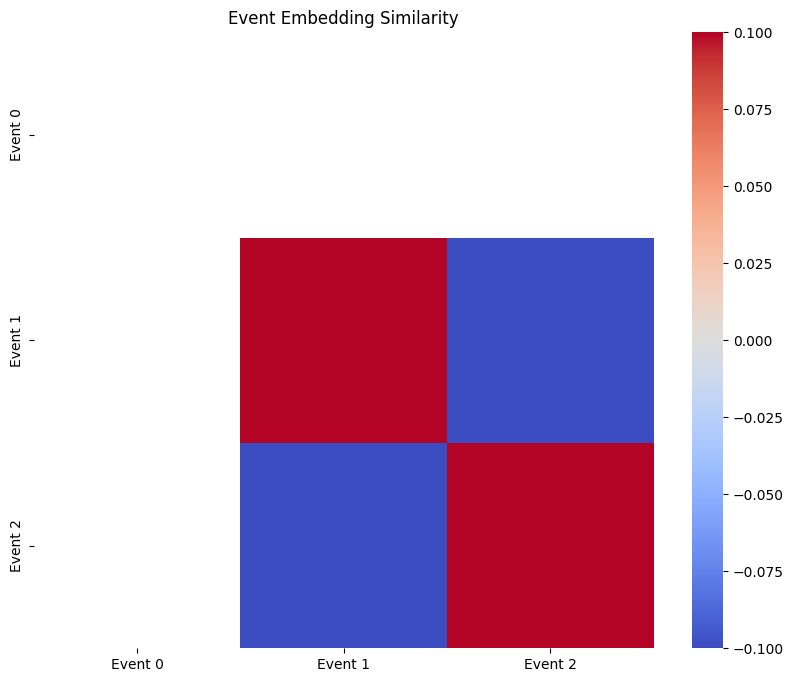

C:\Users\Richard\AppData\Local\Temp\ipykernel_24404\3133360027.py:20: RuntimeWarning: divide by zero encountered in divide
  similarity_matrix /= (norms @ norms.T)  # Normalize
C:\Users\Richard\AppData\Local\Temp\ipykernel_24404\3133360027.py:20: RuntimeWarning: invalid value encountered in divide
  similarity_matrix /= (norms @ norms.T)  # Normalize


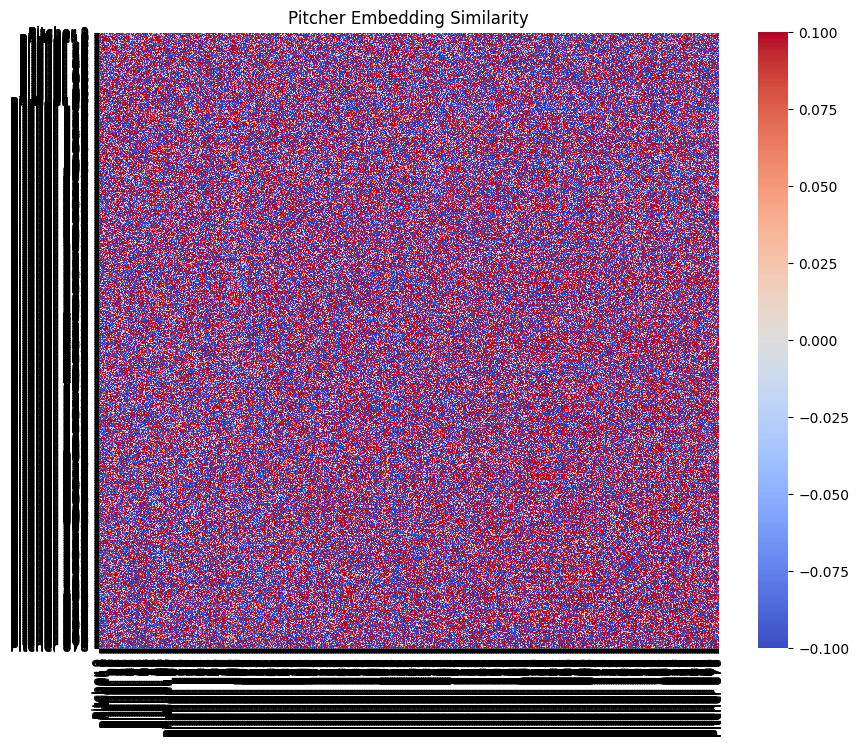

C:\Users\Richard\AppData\Local\Temp\ipykernel_24404\3133360027.py:20: RuntimeWarning: divide by zero encountered in divide
  similarity_matrix /= (norms @ norms.T)  # Normalize
C:\Users\Richard\AppData\Local\Temp\ipykernel_24404\3133360027.py:20: RuntimeWarning: invalid value encountered in divide
  similarity_matrix /= (norms @ norms.T)  # Normalize


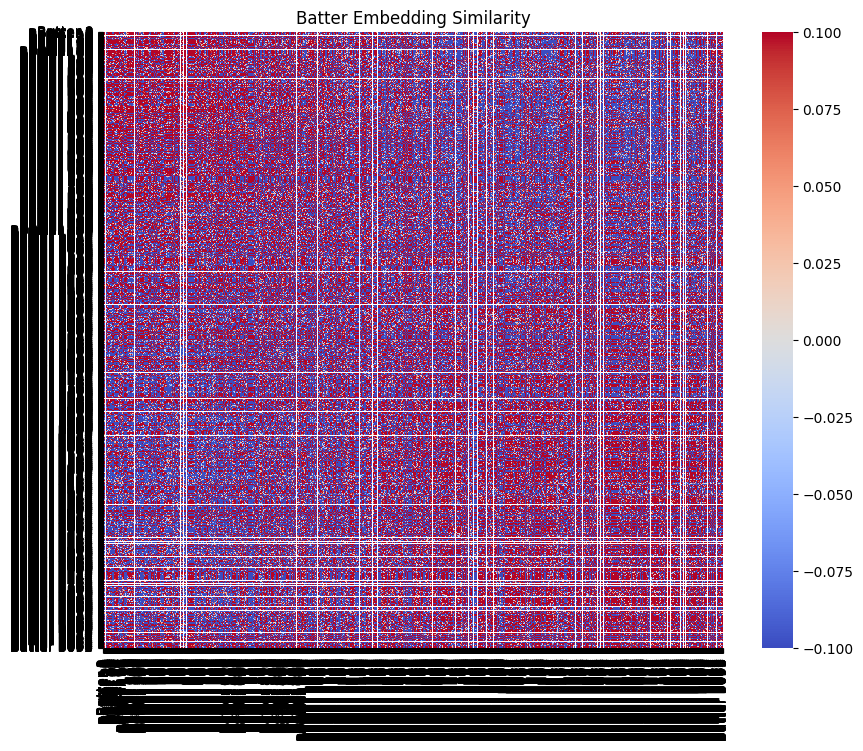

C:\Users\Richard\AppData\Local\Temp\ipykernel_24404\3133360027.py:20: RuntimeWarning: divide by zero encountered in divide
  similarity_matrix /= (norms @ norms.T)  # Normalize
C:\Users\Richard\AppData\Local\Temp\ipykernel_24404\3133360027.py:20: RuntimeWarning: invalid value encountered in divide
  similarity_matrix /= (norms @ norms.T)  # Normalize


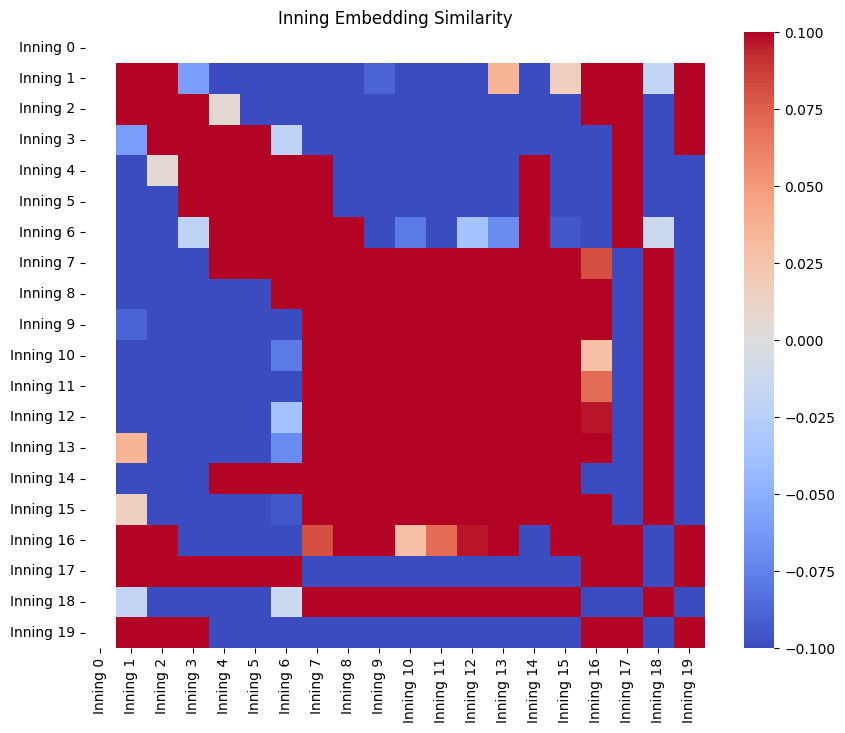

C:\Users\Richard\AppData\Local\Temp\ipykernel_24404\3133360027.py:20: RuntimeWarning: divide by zero encountered in divide
  similarity_matrix /= (norms @ norms.T)  # Normalize
C:\Users\Richard\AppData\Local\Temp\ipykernel_24404\3133360027.py:20: RuntimeWarning: invalid value encountered in divide
  similarity_matrix /= (norms @ norms.T)  # Normalize


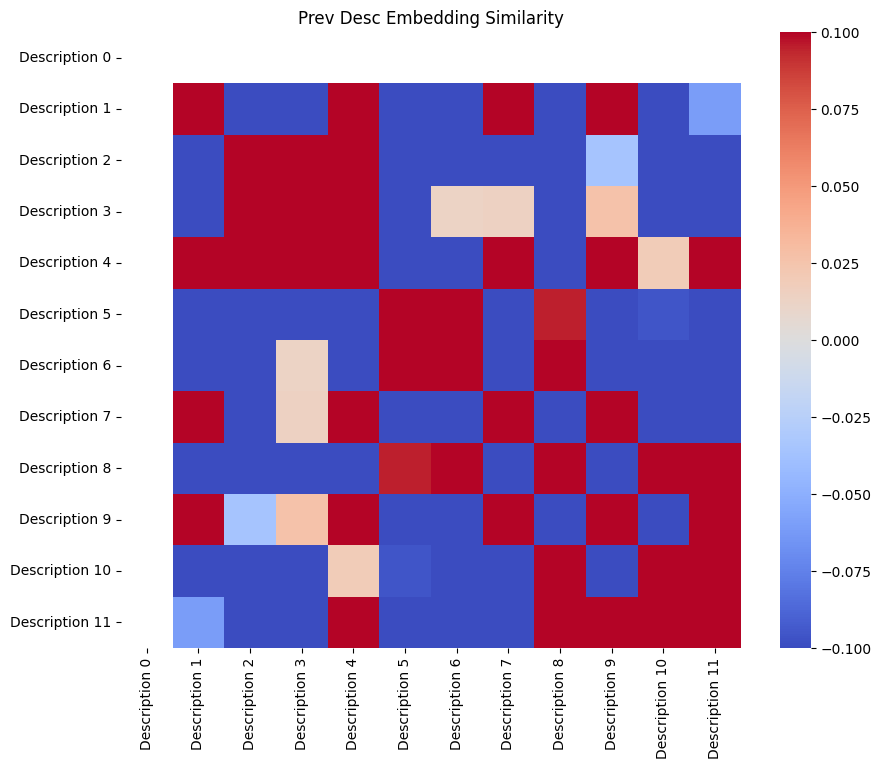

C:\Users\Richard\AppData\Local\Temp\ipykernel_24404\3133360027.py:20: RuntimeWarning: divide by zero encountered in divide
  similarity_matrix /= (norms @ norms.T)  # Normalize
C:\Users\Richard\AppData\Local\Temp\ipykernel_24404\3133360027.py:20: RuntimeWarning: invalid value encountered in divide
  similarity_matrix /= (norms @ norms.T)  # Normalize


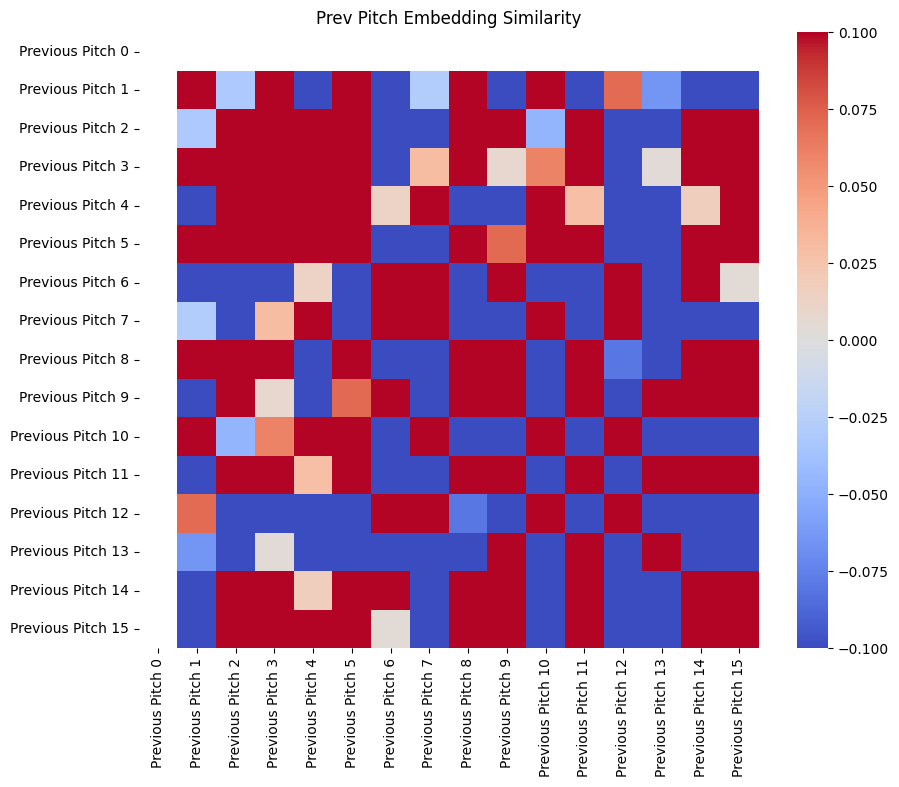

In [30]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def compute_embedding_similarity(embedding_matrix, labels, title="Embedding Similarity"):
    """
    Compute cosine similarity between embeddings and visualize it.
    
    embedding_matrix: torch.Tensor (num_classes, embedding_dim)
    labels: list of class labels
    title: Title for the heatmap
    """
    # Convert embeddings to numpy
    embeddings = embedding_matrix.cpu().detach().numpy()

    # Compute cosine similarity
    similarity_matrix = np.dot(embeddings, embeddings.T)
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    similarity_matrix /= (norms @ norms.T)  # Normalize

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=False, cmap="coolwarm", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.show()

# Extract learned embeddings from the trained model
event_embeddings = model.prev_event_emb.weight  # Shape: (num_events, emb_dim)
pitcher_embeddings = model.pitcher_emb.weight
batter_embeddings = model.batter_emb.weight
inning_embeddings = model.inning_emb.weight
prev_desc_embs = model.prev_description_emb.weight
prev_pitch_embs = model.prev_pitch_emb.weight

# Define labels (Replace with actual event names if available)
event_labels = [f"Event {i}" for i in range(event_embeddings.shape[0])]
pitcher_labels = [f"Pitcher {i}" for i in range(pitcher_embeddings.shape[0])]
batter_labels = [f"Batter {i}" for i in range(batter_embeddings.shape[0])]
inning_labels = [f"Inning {i}" for i in range(inning_embeddings.shape[0])]
prev_desc_labels = [f"Description {i}" for i in range(prev_desc_embs.shape[0])]
prev_pitch_labels = [f"Previous Pitch {i}" for i in range(prev_pitch_embs.shape[0])]

# Compute and visualize event embedding similarity
compute_embedding_similarity(event_embeddings, event_labels, title="Event Embedding Similarity")
compute_embedding_similarity(pitcher_embeddings, pitcher_labels, title="Pitcher Embedding Similarity")
compute_embedding_similarity(batter_embeddings, batter_labels, title="Batter Embedding Similarity")
compute_embedding_similarity(inning_embeddings, inning_labels, title="Inning Embedding Similarity")
compute_embedding_similarity(prev_desc_embs, prev_desc_labels, title="Prev Desc Embedding Similarity")
compute_embedding_similarity(prev_pitch_embs, prev_pitch_labels, title="Prev Pitch Embedding Similarity")


In [ ]:
''' INCREMENT DUE TO PADDING
Column 15 - Total Unique Categories: 15
   CH -> 0 -> 1
   CS -> 1 -> 2
   CU -> 2 -> 3
   EP -> 3 -> 4
   FA -> 4 -> 5
   FC -> 5 -> 6
   FF -> 6 -> 7
   FS -> 7 -> 8
   KC -> 8 -> 9
   KN -> 9 -> 10
   NONE -> 10 -> 11
   SI -> 11 -> 12
   SL -> 12 -> 13
   ST -> 13 -> 14
   SV -> 14 -> 15

Column 21 - Total Unique Categories: 2
   IN_PROGRESS -> 0 -> 1
   NONE -> 1 -> 2

Column 22 - Total Unique Categories: 11
   NONE -> 0 -> 1
   ball -> 1 -> 2
   blocked_ball -> 2 -> 3
   bunt_foul_tip -> 3 -> 4
   called_strike -> 4 -> 5
   foul -> 5 -> 6
   foul_bunt -> 6 -> 7
   foul_tip -> 7 -> 8
   missed_bunt -> 8 -> 9
   swinging_strike -> 9 -> 10
   swinging_strike_blocked -> 10 -> 11

   '''